# Starbucks Capstone Challenge

# I. Project  Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# II. Business Understanding
The problem statements I am trying to answer are here are: 
   * What are the distributions of gender, age, and income of customers in general?
   * What are the distributions offer types alone and based on gender, age, and income of customers that completed the offers?
   * Will a customer respond to an offer?



# III. Data Understanding

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**1- portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)


In [1]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime

import seaborn as sns
sns.set_palette('Set2')
import matplotlib.pyplot as plt

% matplotlib inline


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
portfolio.shape

(10, 6)

**2- profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income


In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [9]:
profile.shape

(17000, 5)

**3- transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [10]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [11]:
transcript.shape

(306534, 4)

In [12]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# III. Data Preparation

In order to proceed and answer the problem statement question, we need first to prepare the data for analysis and modeling. this will be done by clean each dataset them merging the cleaned datasets by proper ids.

**To clean the:**
* portfolio dataset the following was performed: 
  * Copied the dataframe to wrangle the data
  * Created binary columns from each channel in the 'channels' column
  * Created binary columns from each offer type in 'offer_type' column then merge them with cleaned original dataframe 
  * Dropped 'offer_type' and channels columns from cleaned original dataframe
  * Dropped duplicated row if they exist


In [13]:
def clean_portfolio_dataset(df):
    """
    performs the following:
        1- copy the dataframe to wrangle the data
        2- create binary columns from each channel in 'channels' column
        3- create binary columns from each offer type in 'offer_type' column then merge them with cleaned origianl dataframe 
        4- drop 'offer_type' and channels columns from cleaned origianl dataframe
        5- drop duplicated row if they exist
    
    args:
        df (Dataframe): the offers portfolio dataset dataframe
    
    return:
        df (Dataframe): the cleaned offers portfolio dataset dataframe
    """
    
    # copy the dataframe before wrangling the data 
    df = df.copy()
    
    #get the list of unique 'channels'
    channels = set()    
    for row in df.channels:
        channels = channels.union(set(row))
    
    # create binary columns from each channel in 'channels' column
    for channel in channels:
        df[channel] =  df['channels'].apply(lambda x: 1 if channel in x else 0)
    
    # create dataframe binary columns from each offer type in 'offer_type' column 
    df_offer_type = pd.get_dummies(df['offer_type'])
    
    # merge dataframe binary columns from each offer type in 'offer_type' column with cleaned origianl dataframe 
    df = pd.concat([df, df_offer_type], axis=1)
    
    # drop 'offer_type' and channels columns from cleaned origianl dataframe
    df.drop(['channels'], axis = 1, inplace=True)
    
    # drop duplicates
    print("number of duplicates: ", df.duplicated().sum())
    if df.duplicated().sum() > 0:
        df.drop_duplicates(keep = 'first', inplace = True)
        print("number of duplicates after the drop: ", df.duplicated().sum())
    
    
    # rename 'id' column to 'offer_id'
    df.rename(columns={'id':'offer_id'}, inplace=True)
    
    return df

portfolio_clean = clean_portfolio_dataset(portfolio)
portfolio_clean

number of duplicates:  0


,difficulty,duration,offer_id,offer_type,reward,mobile,social,email,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,0,1,1,0,1,0


* profile dataset the following was performed: 
    * Copied the data frame to wrangle the data.
    * Convert 'became_member_on' column type to date.
    * Created dataframe binary columns from each gender in 'gender' column then merge them with cleaned original dataset.
    * Set missing data in 'age' column to nan instead of 118.
    * Categorized customers into their proper age category
    * Created dataframe binary columns from each age category in 'age_category' column then merge them with cleaned original data
    * Dropped duplicated row if they exist
    * Renamed 'id' column to 'user_id'

In [14]:
def clean_profile_dataset(df):
    """
    performs the following:
        1- copy the data frame to wrangle the data
        2- convert 'became_member_on' column type to date
        3- create dataframe binary columns from each gender in 'gender' column then merge them with cleaned origianl data
        4- set missing date in 'age' column to nan instead of 118
        5- categorize customers in to their proper age category
        6- create dataframe binary columns from each age category in 'age_category' column then merge them with cleaned origianl data
        7- drop duplicated row if they exist
        8- rename 'id' column to 'user_id'
    
    args:
        df (Dataframe): the profile dataset dataframe
    
    return:
        df (Dataframe): the cleaned profile dataset dataframe
    """
    
    # copy the dataframe before wrangling the data 
    df = df.copy()
    
    # drop duplicates
    print("number of duplicates: ", df.duplicated().sum())
    if df.duplicated().sum() > 0:
        df.drop_duplicates(keep = 'first', inplace = True)
        print("number of duplicates after the drop: ", df.duplicated().sum())
        
    # convert 'became_member_on' column type to date
    df['became_member_on'] = df['became_member_on'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d') )
    
    # create dataframe binary columns from each gender in 'gender' column 
    df_gender = pd.get_dummies(df['gender'],prefix="gender_")
    
    # merge dataframe binary columns from each gender in 'gender' column with cleaned origianl dataframe 
    df = pd.concat([df, df_gender], axis=1)
    
    # set missing date in 'age' column to nan instead of 118
    df['age'] = df['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # categorize customers in to their proper age category based categories on found in study in https://pubmed.ncbi.nlm.nih.gov/11815703/#:~:text=Participants%20were%20categorized%20by%20age,were%20compared%20across%20the%20groups.
    df['age_category']  = pd.cut(df['age'], bins=[18,35,55,118], labels=['young-adult','adult','elderly'], right=False)
    
    # create dataframe binary columns from each gender in 'gender' column 
    df_age_category = pd.get_dummies(df['age_category'])
    
    # merge dataframe binary columns from each gender in 'gender' column with cleaned origianl dataframe 
    df = pd.concat([df, df_age_category], axis=1)
    
    # rename 'id' column to 'user_id'
    df.rename(columns={'id':'user_id'}, inplace=True)
    
    return df

profile_clean = clean_profile_dataset(profile)

number of duplicates:  0


In [15]:
profile_clean

,age,became_member_on,gender,user_id,income,gender__F,gender__M,gender__O,age_category,young-adult,adult,elderly
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0,0,NaN,0,0,0
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,elderly,0,0,1
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,0,0,0,NaN,0,0,0
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,elderly,0,0,1
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,0,NaN,0,0,0
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,elderly,0,0,1
6,NaN,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,0,0,0,NaN,0,0,0
7,NaN,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN,0,0,0,NaN,0,0,0
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,elderly,0,0,1
9,NaN,2016-11-22,None,8974fc5686fe429db53ddde067b88302,NaN,0,0,0,NaN,0,0,0


* transcript dataset the following was performed: 
    * Copied the dataframe to wrangle the data
    * Created new 'offer_id' and 'transaction_amount' columns with null values
    * Extracted 'transaction_amount' column values from value column values 
    * Extracted 'offer_id' column values from value column values
    * Created binary columns from each transcript event type in 'event' column then merge them with cleaned original dataframe 
    * Dropped 'value' and 'event' columns from cleaned original dataframe
    * Dropped duplicated row if they exist
    * Renamed 'person' column to 'uesr_id'

In [16]:
def extarct_value_column_values_to_transaction_amount_column(transcript):
    """
    extarct 'value' column values from to separate column:
        - if the event column value is 'transaction' then extarct 'amount' value to 'transaction_amount' column
              
    args:
       transcript (Series): row from transcript datafteme
    
    return:
       float as transaction_amount or Nan
    
    """
    if transcript['event'] == 'transaction':
        return transcript['value']['amount']
    else:
        return np.nan
        
def extarct_value_column_values_to_offer_id_column(transcript):
    """
    extarct 'value' column values from to separate columns:
        - if the event column value is not 'transaction' then extarct 'offer id' value to 'offer_id' column
            
    args:
       transcript (Series): row from transcript datafteme
    
    return:
        String as offer_id or None
    """
    if transcript['event'] != 'transaction':
        if 'offer id'in transcript['value'].keys() :
            return transcript['value']['offer id']
        else:
            return transcript['value']['offer_id']
    else:
        return None


def clean_transcript_dataset(df):
    """
    performs the following:
        1- copy the dataframe to wrangle the data
        2- create new 'offer_id' and 'transaction_amount' columns with null values
        3- extarct 'transaction_amount' column values from value column values 
        4- extarct 'offer_id' column values from value column values
        5- create binary columns from each transcript event type in 'event' column then merge them with cleaned origianl dataframe 
        6- drop 'value' and 'event' columns from cleaned origianl dataframe
        7- drop duplicated row if they exist
        8- rename 'person' column to 'uesr_id'
    
    args:
        df (Dataframe): the offers transcript dataset dataframe
    
    return:
        df (Dataframe): the cleaned offers transcript dataset dataframe
    """
    
    # copy the dataframe before wrangling the data 
    df = df.copy()
    
    # create new 'offer_id' and 'transaction_amount' columns with null values
    df['offer_id'] = None
    df['transaction_amount'] = np.nan
    
    # extarct 'transaction_amount' column values from 'value' column values 
    df['transaction_amount'] = df.apply(lambda row : extarct_value_column_values_to_transaction_amount_column(row),axis=1)
    
    # extarct 'offer_id' column values from 'value' column values 
    df['offer_id'] = df.apply(lambda row : extarct_value_column_values_to_offer_id_column(row),axis=1)
    
    
    # create dataframe binary columns from each transcript event in 'event' column 
    df_event = pd.get_dummies(df['event'])
    
    # merge dataframe binary columns from each transcript event in 'event' column with cleaned origianl dataframe 
    df = pd.concat([df, df_event], axis=1)
    
    # drop 'value' and 'event' columns from cleaned origianl dataframe
    df.drop(['value'], axis = 1, inplace=True)
    
    # drop duplicates
    print("number of duplicates: ", df.duplicated().sum())
    if df.duplicated().sum() > 0:
        df.drop_duplicates(keep = 'first', inplace = True)
        print("number of duplicates after the drop: ", df.duplicated().sum())
    
    # rename 'person' column to 'uesr_id'
    df.rename(columns={'person':'user_id'}, inplace=True)
    
    return df

transcript_clean = clean_transcript_dataset(transcript)


number of duplicates:  397
number of duplicates after the drop:  0


In [17]:
transcript_clean.head()

transcript_clean[transcript_clean['event']== 'offer completed' ].head()

,event,user_id,time,offer_id,transaction_amount,offer completed,offer received,offer viewed,transaction
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,NaN,1,0,0,0
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,1,0,0,0
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,0,0,0
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,1,0,0,0
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,1,0,0,0


In [18]:
# merge transcript_clean with portfolio_clean on offer_id
df_starbucks_master = transcript_clean.merge(portfolio_clean,on='offer_id',how='left')

In [19]:
# merge the merged transcript_clean with portfolio_clean datasets to profile_clean on user_id
df_starbucks_master = df_starbucks_master.merge(profile_clean,on='user_id',how='left')

In [20]:
df_starbucks_master.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306137 entries, 0 to 306136
Data columns (total 31 columns):
event                 306137 non-null object
user_id               306137 non-null object
time                  306137 non-null int64
offer_id              167184 non-null object
transaction_amount    138953 non-null float64
offer completed       306137 non-null uint8
offer received        306137 non-null uint8
offer viewed          306137 non-null uint8
transaction           306137 non-null uint8
difficulty            167184 non-null float64
duration              167184 non-null float64
offer_type            167184 non-null object
reward                167184 non-null float64
mobile                167184 non-null float64
social                167184 non-null float64
email                 167184 non-null float64
web                   167184 non-null float64
bogo                  167184 non-null float64
discount              167184 non-null float64
informational         167184 

In [21]:
df_starbucks_master.head()

,event,user_id,time,offer_id,transaction_amount,offer completed,offer received,offer viewed,transaction,difficulty,...,became_member_on,gender,income,gender__F,gender__M,gender__O,age_category,young-adult,adult,elderly
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0,5.0,...,2017-05-09,F,100000.0,1,0,0,elderly,0,0,1
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0,20.0,...,2017-08-04,None,NaN,0,0,0,NaN,0,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0,10.0,...,2018-04-26,M,70000.0,0,1,0,elderly,0,0,1
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0,10.0,...,2017-09-25,None,NaN,0,0,0,NaN,0,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0,10.0,...,2017-10-02,None,NaN,0,0,0,NaN,0,0,0


# IV  Data Analysis / Modeling

In this section, I will attempt to answer the problem statement questions we stated in the Data Understanding section using the dataset that resulted from the Data Preparation section.

The questions are: 

* What are the distributions of the gender, age, and income of customers in general?
* What is the distribution of the offer types alone and based on the gender and age category of customers that completed the offers?
* Will a customer respond to an offer?

## Data Analysis 
To Answer the first two question will use Data Analysis and visualizations.


### - What are the distributions of the gender, age, and income of customers in general?

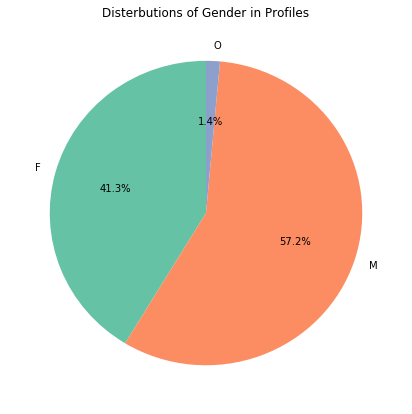

In [22]:
ax = profile_clean.groupby('gender').user_id.count().plot(kind='pie' ,figsize=(7,7)  , startangle=90, autopct='%1.1f%%' , title= "Disterbutions of Gender in Profiles");
ax.set_ylabel("");

You can see from the gender distribution in profile dataset the male profiles counts are greater than females, and that 'other' represents 1.4% of the values.

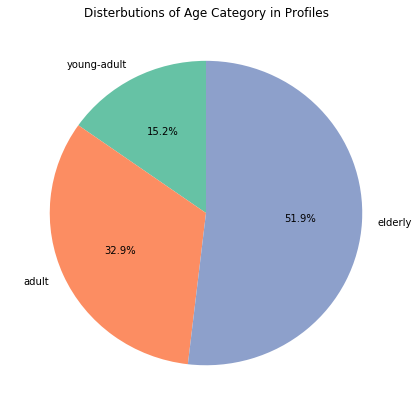

In [23]:
ax= profile_clean.groupby('age_category').user_id.count().plot(kind='pie' ,figsize=(7,7)  , startangle=90, autopct='%1.1f%%' , title= "Disterbutions of Age Category in Profiles");
ax.set_ylabel("");

You can see form the age categories distribution in profile dataset that a little above half (51.9%) of profiles belong to the elderly category followed by 32.9% belong to adults category and young-adults category represent 15.2% of the values.

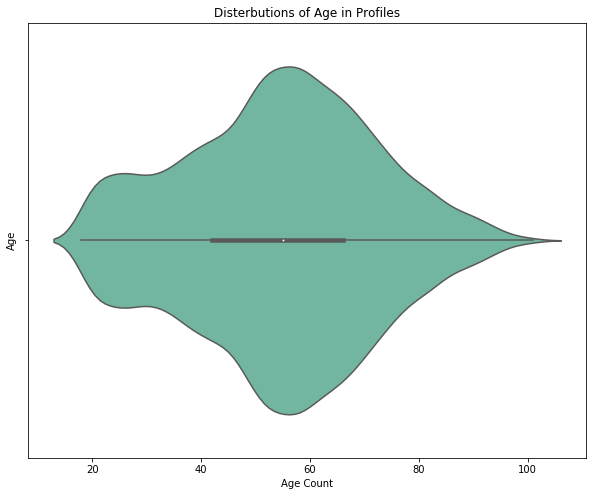

In [24]:

plt.figure(figsize=(10, 8))
sns.violinplot(profile_clean['age'], orient='h')

plt.title('Disterbutions of Age in Profiles')
plt.xlabel('Age Count')
plt.ylabel('Age');

In [25]:
profile_clean.age.mean()

54.393524451939292

You can see from the age distribution in profile dataset that the average income is 54 of the majority profiles ages clustered below the average.

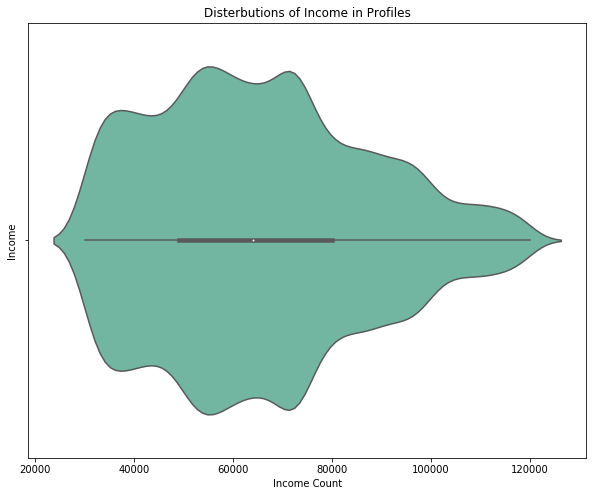

In [26]:
plt.figure(figsize=(10, 8))
sns.violinplot(profile_clean['income'], orient='h')

plt.title('Disterbutions of Income in Profiles')
plt.xlabel('Income Count')
plt.ylabel('Income');

In [27]:
profile_clean.income.mean()

65404.991568296799

You can see from the income distribution in profile dataset that the average income is ~65,400 of the majority profiles have income are clustered below the average.

### - What are the distributions offer types alone and based on gender, age, and income of customers that completed the offers?

In [28]:
df_starbucks_master_offer_completed = df_starbucks_master[transcript.event == 'offer completed']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


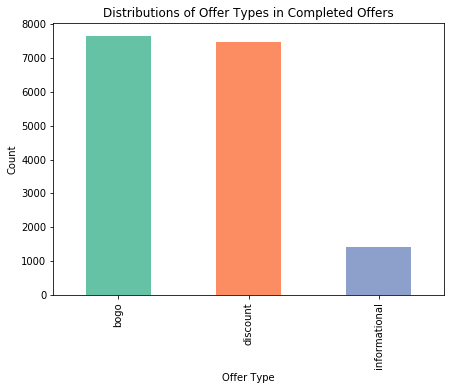

In [29]:
ax = df_starbucks_master_offer_completed.groupby('offer_type')['offer completed'].count().plot(kind='bar' ,figsize=(7,5)  , title= "Distributions of Offer Types in Completed Offers");
ax.set_xlabel("Offer Type")
ax.set_ylabel("Count");

you can see that offers are most popular are Bogo (Buy one get one) followed closely by Discount offers then  Informational offer. 

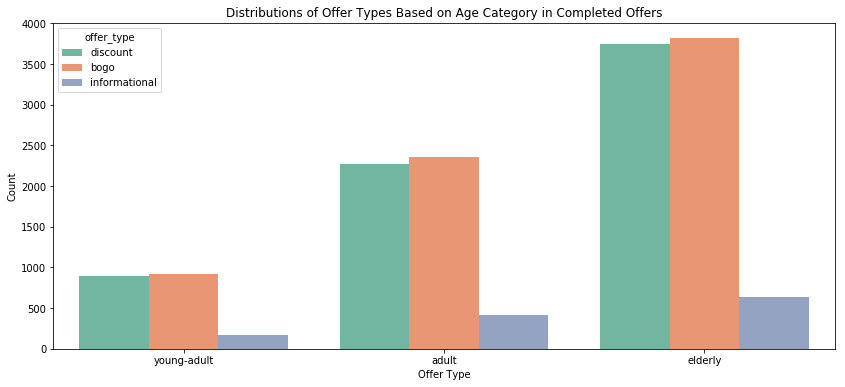

In [30]:

plt.figure(figsize=(14, 6))
sns.countplot(x="age_category", hue="offer_type", data=df_starbucks_master_offer_completed)
plt.title( "Distributions of Offer Types Based on Age Category in Completed Offers");
plt.xlabel("Offer Type")
plt.ylabel("Count");

As you can see the elderly category has the highest offer completion counts with Bogo offers are the most popular offers followed closely by Discount offers then Informational offer. 
Follows the elder in the highest offer completion counts is the adults then young adults both have the same offer types distribution as the elderly.

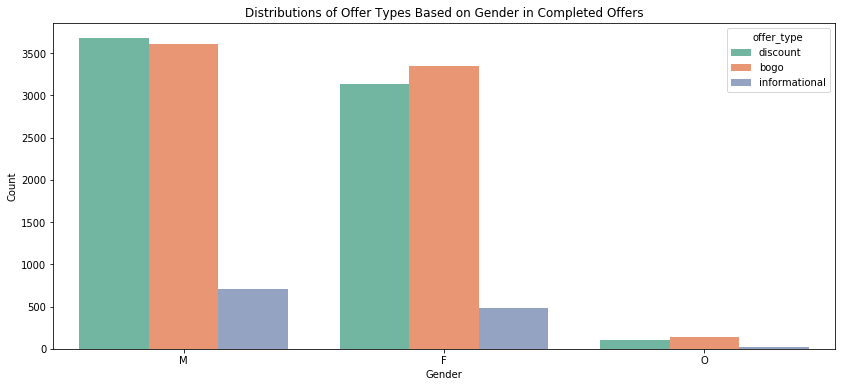

In [31]:
plt.figure(figsize=(14, 6))
sns.countplot(x="gender", hue="offer_type", data=df_starbucks_master_offer_completed)
plt.title( "Distributions of Offer Types Based on Gender in Completed Offers");
plt.xlabel("Gender")
plt.ylabel("Count");

As you can see the males have the highest offer completion counts with Discount offers are the most popular offers followed closely by Bogo offers then Informational offer. 
Follows the males in the highest offer completion counts are the females then 'other's both have the have offer types distribution as Bogo offers are the most popular offers followed closely by Discount offers then Informational offer.

In [32]:
df_starbucks_master_offer_completed.groupby('offer_type')['offer completed'].count()

offer_type
bogo             7649
discount         7459
informational    1420
Name: offer completed, dtype: int64

## Data Modeling
To answer the last question will use Data Modeling.

To answer the question:
### - Will a customer respond to an offer?
we will look into records of transcripts where the customer has viewed the offer from the merged data set (df_starbucks_master) and use the 'offer completed' as the target for our model, thus eliminating any transaction related columns and rows.

we start by fetching offer completed and offer viewed rows then merge them together:

In [33]:
# get offer viewed rows 
df_starbucks_master_offer_viewed= df_starbucks_master[df_starbucks_master['offer viewed']==1]
# drop offer completed column from offer viewed rows
df_starbucks_master_offer_viewed.drop(['offer completed'], axis = 1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [34]:
# get offer completed rows with three columns 'offer_id','user_id' and 'offer completed'
df_starbucks_master_offer_completed= df_starbucks_master[df_starbucks_master['offer completed']==1][['offer_id','user_id', 'offer completed']]

In [35]:
# get offer completed and offer viewed rows 
df_modeling = df_starbucks_master_offer_viewed.merge(df_starbucks_master_offer_completed,right_on=['offer_id','user_id'],left_on=['offer_id','user_id'],how='left')

In [36]:
# fill missing values in offer completed  column with 0
df_modeling['offer completed'].fillna(0,inplace=True)
df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65580 entries, 0 to 65579
Data columns (total 31 columns):
event                 65580 non-null object
user_id               65580 non-null object
time                  65580 non-null int64
offer_id              65580 non-null object
transaction_amount    0 non-null float64
offer received        65580 non-null uint8
offer viewed          65580 non-null uint8
transaction           65580 non-null uint8
difficulty            65580 non-null float64
duration              65580 non-null float64
offer_type            65580 non-null object
reward                65580 non-null float64
mobile                65580 non-null float64
social                65580 non-null float64
email                 65580 non-null float64
web                   65580 non-null float64
bogo                  65580 non-null float64
discount              65580 non-null float64
informational         65580 non-null float64
age                   57592 non-null float64
became_

**now we start removing data colunms:**

* gender: because we already extracted the values in three different columns: gender__F, gender__M, and gender__O.
* age_category and age: because we already extracted and summarized the values in three different columns categories: young-adult, adult, and elderly.
* offer_type because we already extracted the values in three different columns: BOGO, discount, and informational.
* event, offers received, offer viewed, and transaction: because we already extracted to build the modeling data frame.
* transaction_amount: because they are only related to transaction events.
* user_id, offer_id, and became_member_on: because they would not add a thing to the model.

**then well fill the missing values in income column with income column mean.**



In [37]:
columns_to_drop = ['gender','age','age_category','became_member_on','event', 'offer_type',
                    'offer received', 'offer viewed' , 'transaction','transaction_amount',
                    'offer_id','user_id']

# removing data colunms
df_modeling.drop(columns_to_drop, axis = 1, inplace=True)

# fill the missing values in income column with income column mean.
df_modeling.income.fillna(df_modeling.income.mean(), inplace=True)

In [38]:
df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65580 entries, 0 to 65579
Data columns (total 19 columns):
time               65580 non-null int64
difficulty         65580 non-null float64
duration           65580 non-null float64
reward             65580 non-null float64
mobile             65580 non-null float64
social             65580 non-null float64
email              65580 non-null float64
web                65580 non-null float64
bogo               65580 non-null float64
discount           65580 non-null float64
informational      65580 non-null float64
income             65580 non-null float64
gender__F          65580 non-null uint8
gender__M          65580 non-null uint8
gender__O          65580 non-null uint8
young-adult        65580 non-null uint8
adult              65580 non-null uint8
elderly            65580 non-null uint8
offer completed    65580 non-null float64
dtypes: float64(12), int64(1), uint8(6)
memory usage: 7.4 MB


**After that, I'll Split the dataset to train and test datasets.**

In [39]:
from sklearn.model_selection import train_test_split
# set the features data set
features = df_modeling.drop(['offer completed'], axis = 1)
# set the target data set
target = df_modeling['offer completed']
# split data set to training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

**Then I'll Test several algorithms of the train and test datasets and assess them base on the model accuracy:**

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
# set Classifieries
KN  = KNeighborsClassifier()
DT  = DecisionTreeClassifier()
RF  = RandomForestClassifier()
MLP = MLPClassifier()
ADA = AdaBoostClassifier()
GNB = GaussianNB()
SVM = SVC()

# create data frame that will store Classifieries results
df_clfs_results = pd.DataFrame(columns = ['Classifier', 'Training Accuracy','Testing Accuracy'])

# set Classifieries in dict
clfs = {    'KNeighbors' : KN,
            'Decision Tree' : DT,
            'Random Forest' : RF,
            'Neural Network' : MLP,
            'AdaBoost' : ADA,
            'Gaussian Naive Bayes' : GNB,
            'SVM' : SVM   }

# loop over Classifieries in dict
for clf_name, clf in clfs.items():
    
    # train classifier
    trianed_clf = clf.fit( X_train , y_train )
    
    # predict on training dataset
    prediction_train = trianed_clf.predict( X_train )
    
    # predict on testing dataset
    prediction_test = trianed_clf.predict(X_test)
    
    # accuracy on training dataset
    accuracy_train = accuracy_score( y_train , prediction_train )
    
    # accuracy on testing dataset
    accuracy_test = accuracy_score( y_test , prediction_test )
    
    # set classifier result to dict
    clf_result = {'Classifier': clf_name, 'Training Accuracy': accuracy_train, 'Testing Accuracy' :accuracy_test}
    
    # display classifier clf_result dict 
    print(clf_result)
    # add classifier result to df_clfs_results dataframe
    df_clfs_results = df_clfs_results.append(pd.DataFrame(clf_result,index=[0]),ignore_index = True)


{'Classifier': 'KNeighbors', 'Training Accuracy': 0.81774931381518756, 'Testing Accuracy': 0.73961573650503198}
{'Classifier': 'Decision Tree', 'Training Accuracy': 0.95718206770356817, 'Testing Accuracy': 0.75602317779810913}
{'Classifier': 'Random Forest', 'Training Accuracy': 0.94732133780624173, 'Testing Accuracy': 0.77291857273559017}
{'Classifier': 'Neural Network', 'Training Accuracy': 0.57430110806140089, 'Testing Accuracy': 0.56858798414150657}
{'Classifier': 'AdaBoost', 'Training Accuracy': 0.81040967774728068, 'Testing Accuracy': 0.80365965233302838}
{'Classifier': 'Gaussian Naive Bayes', 'Training Accuracy': 0.73646436921825764, 'Testing Accuracy': 0.72955169258920405}
{'Classifier': 'SVM', 'Training Accuracy': 0.89852597336586359, 'Testing Accuracy': 0.74321439463250993}


# V. Evaluation
In this section, I'm going to evaluate the results of the models.

### Metrics:

As we have a simple classification problem, Accuracy is the metric i choose to evaluate my models. This is because we want to see how well our models are preforming by evaluating the ratio of correctly classied predictions from the total predictions of the model.

In [41]:
# display df_clfs_results dataframe  
df_clfs_results

,Classifier,Training Accuracy,Testing Accuracy
0,KNeighbors,0.817749,0.739616
1,Decision Tree,0.957182,0.756023
2,Random Forest,0.947321,0.772919
3,Neural Network,0.574301,0.568588
4,AdaBoost,0.810410,0.803660
5,Gaussian Naive Bayes,0.736464,0.729552
6,SVM,0.898526,0.743214


From the table above, you can see that KNeighbors, Decision Tree, Random Forest, and SVM the large difference in accuracy between the test and train accuracy this means the models are overfitting. So I chose AdaBoost classifier as it had the best results to search for the best parameters to get better results.

In [42]:
from sklearn.model_selection import GridSearchCV
# set parameters for grid search  
parameters = {
 'n_estimators': [50, 100,150,200],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
    'algorithm':['SAMME', 'SAMME.R']
 }
    
# use grid search to find better parameters
model = GridSearchCV(ADA, param_grid=parameters, n_jobs = -1, scoring='accuracy')
model.fit(X_train,y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150, 200], 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1], 'algorithm': ['SAMME', 'SAMME.R']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [43]:
print("best parameters:", model.best_params_)


best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.3, 'n_estimators': 200}


In [44]:
# set Classifier
refined_ADA =AdaBoostClassifier(algorithm='SAMME.R',learning_rate=0.3, n_estimators=200)

# train classifier
trianed_clf = refined_ADA .fit( X_train , y_train )
    
# predict on training dataset
prediction_train = trianed_clf.predict( X_train )
    
# predict on testing dataset
prediction_test = trianed_clf.predict(X_test)
    
# accuracy on training dataset
accuracy_train = accuracy_score( y_train , prediction_train )
    
# accuracy on testing dataset
accuracy_test = accuracy_score( y_test , prediction_test )

clf_result = {'Classifier': 'AdaBoost', 'Training Accuracy': accuracy_train, 'Testing Accuracy' :accuracy_test}

print(clf_result)


{'Classifier': 'AdaBoost', 'Training Accuracy': 0.81055199756023177, 'Testing Accuracy': 0.80396462336078067}


After using Grid Search with AdaBoost I managed to get slightly better results as shown here:


In [45]:
print('Best parameters form AdaBoost:', model.best_params_)
print('Training Accuracy: ',clf_result['Training Accuracy'], ', Testing Accuracy: ',clf_result['Testing Accuracy'])

Best parameters form AdaBoost: {'algorithm': 'SAMME.R', 'learning_rate': 0.3, 'n_estimators': 200}
Training Accuracy:  0.81055199756 , Testing Accuracy:  0.803964623361


Almost a 0.03% increase.


# VI. Conclusion

So Finally, After analyzing the data I found that:

* BOGO offers have are more popular as higher completing offers counts and follows Discount offer so you might Starbucks might want to send focus on sending offers of these types.
* Males have a higher count in completing offers so Starbucks might want to send more offers to them
* The elderly age category has a higher count in completing offers so Starbucks might want to send more offers to them.

Also, The question that wanted to answer was whether a customer will respond to an offer or not. am to answer it My technique to answer the qusetion we going through the following steps.

* Fetching offer completed and offer viewed rows then merge them together.
* Removing data columns that are not related to the model or had been replaced by other columns.
* Splitting the dataset to train and test datasets.
* Testing several algorithms of the train and test datasets and assess them base on the model accuracy.
* Choosing the best model then refine its parameters using grid search.

So the result was the algorithm the had the best classification result was AdaBoost with accuracy of 80.39%.

#  VII.  Improvements

To make our results even better, I feel information about customers was limited we only had just age, gender, and income. To find demographic groups respond best to offers, it would better to have more features of the customers.